In [55]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,8)

import os
import datetime

from astropy import units as u
from astropy.coordinates import SkyCoord, ICRS

OBSV_DATE = datetime.date(year=2022, month=11, day=26).strftime("%Y-%m-%d")

OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"

DATE_DATA_DIR = [os.path.join(OBJ_DATA_DIR, d) for d in os.listdir(OBJ_DATA_DIR) if OBSV_DATE in d and os.path.isdir(os.path.join(OBJ_DATA_DIR, d))][0]
CCD_KWARGS = {'unit': 'adu'}

OBJ_COORD = SkyCoord(339.94692562872, 45.14639621713, unit=u.deg, frame=ICRS)

# Coordinates obtained from SIMBAD Gaia DR3 measurements
REF_OBJS_COORDS = {
	# Not currently used; outside of frame
	# "HD 214804": SkyCoord(340.00377780131, 45.24015031351, unit=u.deg, frame=ICRS), # http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%404410&Name=HD%20214804
	
	"TYC 3620-332-1": SkyCoord(339.88604238078, 45.12830357108, unit=u.deg, frame=ICRS), # http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%406898038&Name=TYC%203620-332-1
	"TYC 3620-254-1": SkyCoord(339.99378670432, 45.10213449513, unit=u.deg, frame=ICRS) # http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%406898031&Name=TYC%203620-254-1
}

DATA_DIR = os.path.join(DATE_DATA_DIR, "corrected", "iraf-shifted")
assert os.path.exists(DATA_DIR), f"{DATA_DIR} not found"
DATA_DIR

'/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-11-26/corrected/iraf-shifted'

In [2]:
import math

from lmfit.model import ModelResult

def percentile(fitResult: ModelResult, percentile: float) -> float:
	"""
	Assumes percentile is given as its percent value (ie. 1 <= percentile <= 99)
	"""
	assert percentile >= 1 and percentile <= 99
	return fitResult.params['sigma'] * math.sqrt(2 * math.log(100.0 / (100 - percentile)))

def plotRadialModel(fitResult: ModelResult, radialProfile: np.ndarray, radialXCoords: np.ndarray, objCenterX: int):
	_, ax = plt.subplots(nrows=1, ncols=1)
	modelCenter = fitResult.params['center'].value + np.median(radialXCoords)

	ax.scatter(radialXCoords, radialProfile)
	ax.plot(radialXCoords, fitResult.best_fit, '--', color='green')
	ax.axvline(objCenterX, color='red')
	ax.axvline(modelCenter, color='orange', marker="2")

	ax.axvline(modelCenter - (fitResult.params['fwhm']/2), color='cyan', marker='2')
	ax.axvline(modelCenter + (fitResult.params['fwhm']/2), color='cyan', marker='2')

	percentile80 = percentile(fitResult, 80)
	ax.axvline(modelCenter - (percentile80), color='purple')
	ax.axvline(modelCenter + (percentile80), color='purple')

	percentile90 = percentile(fitResult, 90)
	ax.axvline(modelCenter - (percentile90), color='blue')
	ax.axvline(modelCenter + (percentile90), color='blue')

	percentile99 = percentile(fitResult, 99)
	ax.axvline(modelCenter - percentile99, color='pink')
	ax.axvline(modelCenter + percentile99, color='pink')

	plt.show()

TYC 3620-332-1: (1151.900869272123, 95.89337542207069)
TYC 3620-254-1: (1364.1268868062778, 885.6004947614143)
Obj. y-pos: 518.6058654256741
45 samples used of 72 seen
R^2 - 
	Mean: 0.8163904181110778 
	Median: 0.816508468076794 
	Range: (0.7151068895041602, 0.9364300200561337)
P90W - 
	Mean: 13.574643265896404 
	Median: 13.45691897159072 
	Range: (10.175049803865667, 18.49763411998598)
P99W - 
	Mean: 19.197444611007302 
	Median: 19.0309573173794 
	Range: (14.389693430448528, 26.15960504429949)
Obj. x-pos - 
	Mean: 937.4286928638759
	Median: 937.4168097507425
	Range: (936.079999503706, 939.6572233412617)


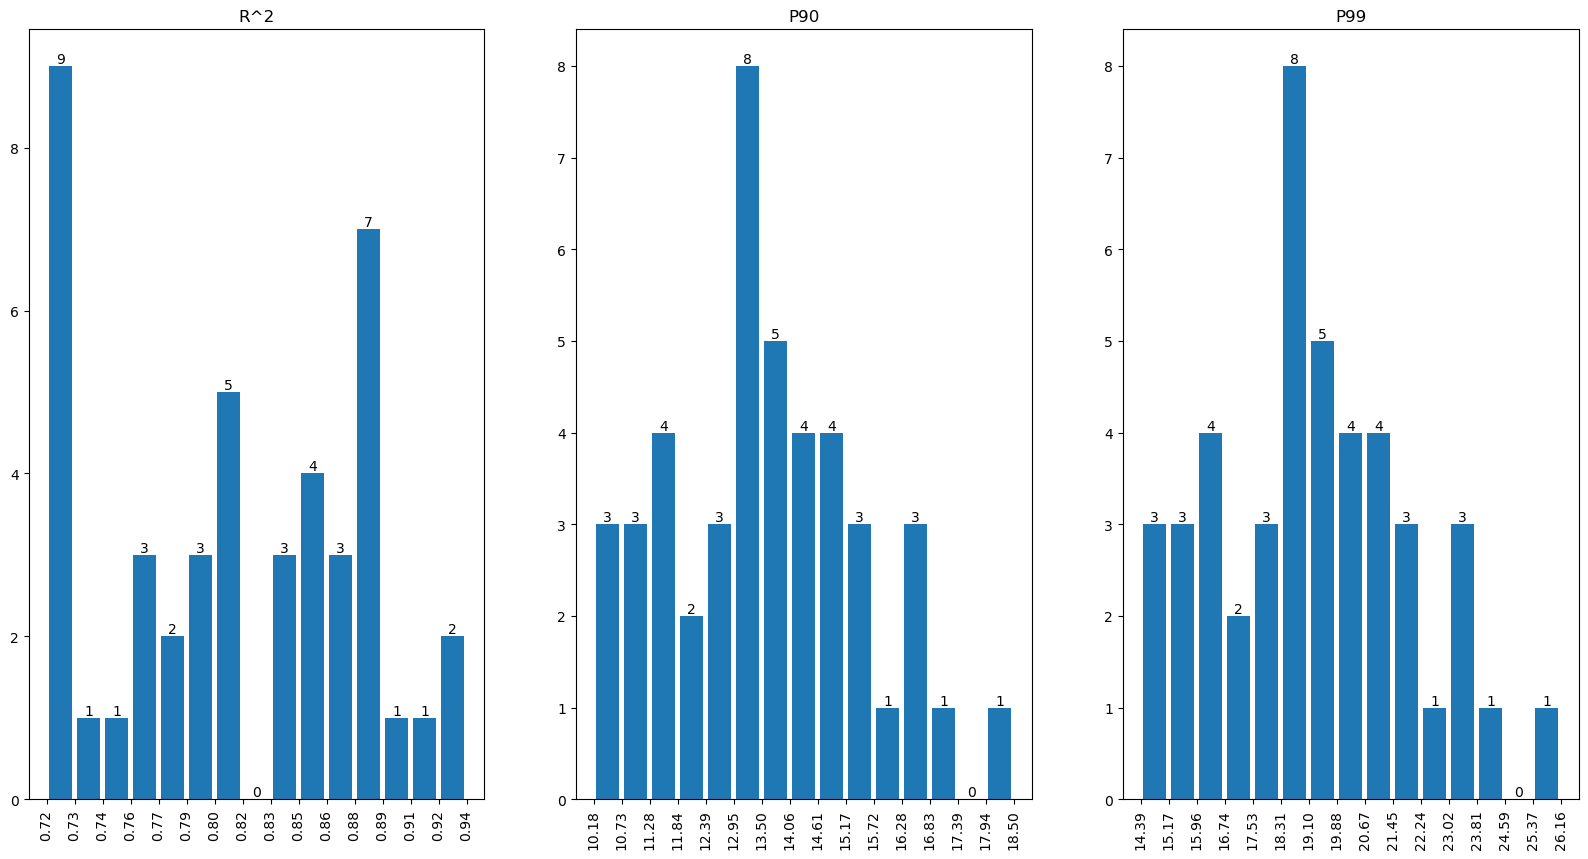

In [56]:
# IMPORTANT: percentiles are printed without multiplying by 2 because IRAF qphot requires aperture RADII, not diameter

import ccdproc

from lmfit.models import GaussianModel, ConstantModel
from lmfit import report_fit
from IPython.display import clear_output
from astropy.visualization import SqrtStretch, ImageNormalize, ZScaleInterval

from astropy import log
log.setLevel('ERROR')

INTERACTIVE = False
RSQUARED_THRESHOLD = 0.7

obsvImages = ccdproc.ImageFileCollection(DATA_DIR)
model = GaussianModel() + ConstantModel()

fitsUsed = 0
totalFits = 0
p90Stats = []
p99Stats = []
modelXCenters = []
rSquared = []
for img, img_fname in obsvImages.ccds(ccd_kwargs=CCD_KWARGS, return_fname=True):
	objPxCoord = OBJ_COORD.to_pixel(img.wcs)
	objCenterX, objCenterY = round(objPxCoord[0].item()), round(objPxCoord[1].item())

	if totalFits == 0:
		for refSkyName, refSkyCoord in REF_OBJS_COORDS.items():
			refPxCoord = refSkyCoord.to_pixel(img.wcs)
			refCenterX, refCenterY = refPxCoord[0].item(), refPxCoord[1].item()
			print(f"{refSkyName}: ({refCenterX}, {refCenterY})")
		print(f"Obj. y-pos: {objPxCoord[1].item()}")
	
	totalFits = totalFits + 1

	# Had to flip X and Y coords due to FITS data shape
	RADIUS = 30
	radialXCoords = np.arange(objCenterX-RADIUS, objCenterX+RADIUS)
	radialProfile = img.data[objCenterY, radialXCoords]
	radialProfile -= np.median(radialProfile)

	# Remove bad pixels, just in case
	imgMask = ~np.isnan(radialProfile)
	correctedRadialProf = radialProfile[imgMask]
	correctedXCoords = radialXCoords[imgMask]

	normalizedX = radialXCoords - np.median(radialXCoords)
	fitResult: ModelResult
	try:
		fitResult = model.fit(correctedRadialProf, x=normalizedX)
	except Exception as e:
		print(f"Error modeling {img_fname}", e)
		continue
	
	if INTERACTIVE and fitResult.rsquared >= RSQUARED_THRESHOLD:
		print(img_fname)

		report_fit(fitResult)
		print(fitResult.params)
		fitResult.plot()
		
		print('--------------------')
		print("R^2", fitResult.rsquared)
		plotRadialModel(fitResult, radialProfile, radialXCoords, objCenterX)
		
		print("Model center: ", (np.median(radialXCoords) + fitResult.params['center'], objPxCoord[1].item()))
		print('--------------------')
		print("WHM: ", fitResult.params['fwhm'].value)
		print("p80: ", percentile(fitResult, 80))
		print("p90: ", percentile(fitResult, 90))
		print("p99: ", percentile(fitResult, 99))
		
		norm = ImageNormalize(img, interval=ZScaleInterval(), stretch=SqrtStretch())
		plt.imshow(img.data, cmap='gray', origin='lower', norm=norm)
		plt.colorbar()

		plt.scatter(objCenterX, objCenterY, marker='.', alpha=0.6, edgecolors='blue', facecolors='none', s=300)
		plt.scatter(np.median(radialXCoords) + fitResult.params['center'], objCenterY, marker='.', alpha=0.6, edgecolors='orange', facecolors='none', s=300)
		for refSkyName, refSkyCoord in REF_OBJS_COORDS.items():
			refPxCoord = refSkyCoord.to_pixel(img.wcs)
			refCenterX, refCenterY = refPxCoord[0].item(), refPxCoord[1].item()
			print(f"{refSkyName}: ({refCenterX}, {refCenterY})")
			plt.scatter(refCenterX, refCenterY, marker='.', alpha=0.6, edgecolors='red', facecolors='none', s=300)

		plt.show()
		input()
		clear_output()
		plt.clf()

	if fitResult.rsquared < RSQUARED_THRESHOLD:
		continue

	fitsUsed += 1
	modelXCenters.append(np.median(radialXCoords) + fitResult.params['center'])
	p90Stats.append(percentile(fitResult, 90))
	p99Stats.append(percentile(fitResult, 99))
	rSquared.append(fitResult.rsquared)
print(fitsUsed, "samples used of", totalFits, "seen")
print(f"""R^2 - 
	Mean: {np.mean(rSquared)} 
	Median: {np.median(rSquared)} 
	Range: ({np.min(rSquared)}, {np.max(rSquared)})""")
print(f"""P90W - 
	Mean: {np.mean(p90Stats)} 
	Median: {np.median(p90Stats)} 
	Range: ({np.min(p90Stats)}, {np.max(p90Stats)})""")
print(f"""P99W - 
	Mean: {np.mean(p99Stats)} 
	Median: {np.median(p99Stats)} 
	Range: ({np.min(p99Stats)}, {np.max(p99Stats)})""")
print(f"""Obj. x-pos - 
	Mean: {np.mean(modelXCenters)}
	Median: {np.median(modelXCenters)}
	Range: ({np.min(modelXCenters)}, {np.max(modelXCenters)})""")

def plotHistogram(data, ax, title, bins=15):
	_, plotBins, bars = ax.hist(data, bins=bins, rwidth=0.8)
	ax.set_title(title)
	ax.bar_label(bars)
	ax.set_xticks(plotBins, labels=[f"{b:.2f}" for b in plotBins], rotation='vertical')

fig, axs = plt.subplots(1, 3, figsize=(20, 10))
plotHistogram(rSquared, axs[0], "R^2")
plotHistogram(p90Stats, axs[1], "P90")
plotHistogram(p99Stats, axs[2], "P99")
plt.show()

In [52]:
# Aperture photometry, NOT FUNCTIONAL

# from photutils.aperture import SkyCircularAperture, aperture_photometry
# from astropy.wcs import WCS

# DATE_OBSV_FIELD = "DATE-OBS"

# obsvImages = ccdproc.ImageFileCollection(DATA_DIR)

# aperture = SkyCircularAperture(OBJ_COORD, r=0.28 * u.arcsec)
# starFlux: None
# for img, img_fname in obsvImages.ccds(ccd_kwargs=CCD_KWARGS, return_fname=True):
# 	starFlux = aperture_photometry(img, aperture)
# 	dateObsv = img.header[DATE_OBSV_FIELD]
# 	break
# starFlux

id,xcenter,ycenter,sky_center,aperture_sum
,pix,pix,"deg,deg",adu
int64,float64,float64,SkyCoord,float64
1,1013.9056131219165,605.4863169877364,"339.94692562872,45.14639621713",6384.084107099893
